In [200]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler

In [153]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [154]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import AUC
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from keras.losses import BinaryFocalCrossentropy

# Preprocessing

In [155]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [156]:
train.shape

(165034, 11)

In [196]:
X = train.drop(columns='Exited')
y = train.Exited

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [203]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [205]:
y_resampled.value_counts(True)

Exited
0    0.5
1    0.5
Name: proportion, dtype: float64

In [206]:
prepro = Preprocessing()

In [207]:
X_train_scld = prepro.fit_transform(X_resampled).astype(float)
X_test_scld = prepro.transform(X_test).astype(float)

In [161]:
X_train_scld

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
id,,,,,,,,,,,,
111990,0.544643,0.0,0.5,-1.00,0.965374,0.0,0.0,1.0,-0.185996,1.0,0.0,0.0
20302,0.142857,0.0,2.2,-0.25,0.000000,0.0,1.0,1.0,-0.311088,1.0,0.0,0.0
164200,-0.473214,1.0,-0.5,1.00,1.203104,0.0,1.0,0.0,0.727266,0.0,1.0,0.0
155007,-0.294643,0.0,0.2,1.00,1.401633,-1.0,1.0,0.0,-0.905207,1.0,0.0,0.0
147977,0.741071,1.0,0.0,-0.50,0.000000,0.0,1.0,1.0,0.048851,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
116984,1.026786,1.0,-0.6,-0.75,0.000000,0.0,1.0,1.0,-0.787107,1.0,0.0,0.0
132666,0.482143,1.0,-0.5,0.75,0.647069,-1.0,0.0,1.0,0.563358,1.0,0.0,0.0
41759,-0.348214,1.0,0.5,-0.50,0.000000,0.0,0.0,1.0,0.165653,1.0,0.0,0.0


# Model

In [208]:
X_train_scld.shape

(52382, 12)

In [220]:
model = Sequential(name="BankChurn")
model.add(Dense(units=16, activation='relu',kernel_initializer='he_normal', input_dim=12, name="Dense1"))
model.add(Dropout(0.1, name="Dropout1"))
model.add(Dense(units=8, activation='relu',kernel_initializer='he_normal',name="Dense2"))
model.add(Dropout(0.1, name="Dropout2"))
model.add(Dense(units=4, activation='relu',kernel_initializer='he_normal',name="Dense3"))

model.add(Dense(units=1, activation='sigmoid',kernel_initializer='glorot_uniform',  name="Output"))



model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss=BinaryFocalCrossentropy(),
    metrics=['accuracy']
    )
model.summary()

Model: "BankChurn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense1 (Dense)              (None, 16)                208       
                                                                 
 Dropout1 (Dropout)          (None, 16)                0         
                                                                 
 Dense2 (Dense)              (None, 8)                 136       
                                                                 
 Dropout2 (Dropout)          (None, 8)                 0         
                                                                 
 Dense3 (Dense)              (None, 4)                 36        
                                                                 
 Output (Dense)              (None, 1)                 5         
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 K

In [222]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scld.values,
    y_resampled.values,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    #callbacks=[early_stopping]
    )

Epoch 1/100
1310/1310 [==============================] - 13s 10ms/step - loss: 1.1264 - accuracy: 0.3899 - val_loss: 0.1050 - val_accuracy: 0.8627
Epoch 2/100
1310/1310 [==============================] - 12s 9ms/step - loss: 1.0874 - accuracy: 0.3894 - val_loss: 0.1080 - val_accuracy: 0.8572
Epoch 3/100
1310/1310 [==============================] - 12s 9ms/step - loss: 1.0415 - accuracy: 0.3937 - val_loss: 0.1112 - val_accuracy: 0.8522
Epoch 4/100
1310/1310 [==============================] - 12s 9ms/step - loss: 0.9984 - accuracy: 0.3951 - val_loss: 0.1144 - val_accuracy: 0.8462
Epoch 5/100
1310/1310 [==============================] - 12s 9ms/step - loss: 0.9544 - accuracy: 0.3994 - val_loss: 0.1178 - val_accuracy: 0.8407
Epoch 6/100
1310/1310 [==============================] - 12s 9ms/step - loss: 0.9211 - accuracy: 0.4002 - val_loss: 0.1213 - val_accuracy: 0.8336
Epoch 7/100
1310/1310 [==============================] - 12s 9ms/step - loss: 0.8784 - accuracy: 0.4025 - val_loss: 0.1250 

In [223]:
def plot_history(history):
    x = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(history.history['val_accuracy'],'r', label='Validation accuracy')
    plt.title('Training and validation auc')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

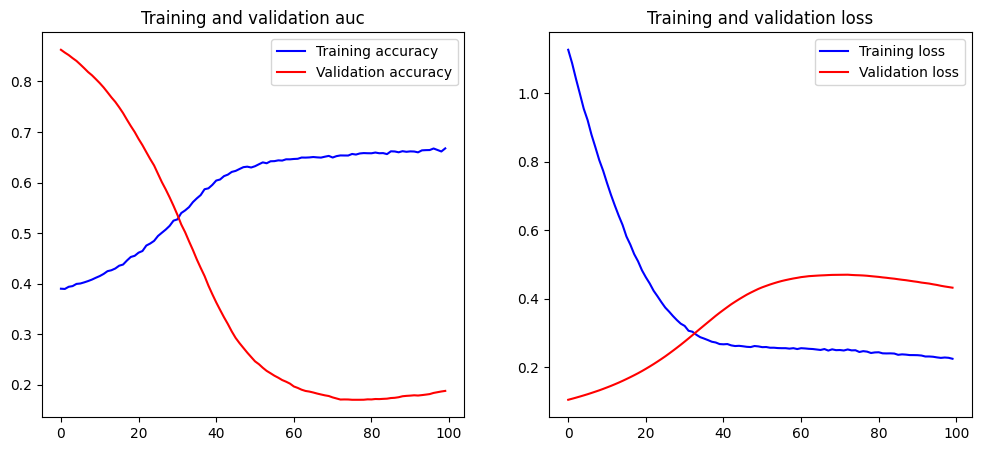

In [224]:
plot_history(history)

In [216]:
pred = model.predict(X_test_scld.values)

1290/1290 [==============================] - 2s 1ms/step


In [217]:
pred[:,0]

array([0.86408466, 0.8944931 , 0.73961854, ..., 0.93336153, 0.7735832 ,
       0.546144  ], dtype=float32)

# Score

In [218]:
RocScore  = roc_auc_score(y_test, pred[:,0])
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.239801


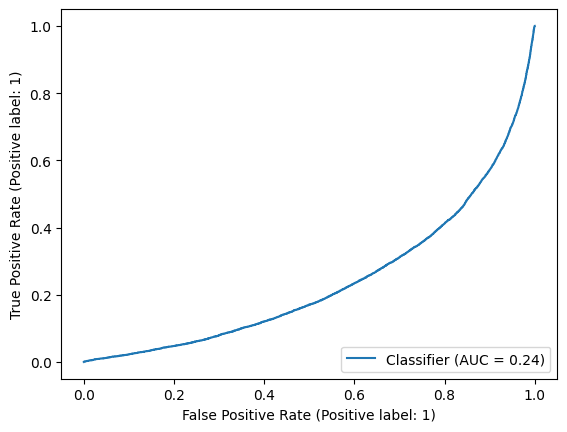

In [219]:
RocCurveDisplay.from_predictions(y_test,pred)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred[:,0]>0.5))

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

,Exited
id,
165034,0.085936
165035,0.947197
165036,0.079534
165037,0.519489
165038,0.638603
...,...
275052,0.132850
275053,0.217605
275054,0.071276


In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
#submission.to_csv(f"submission/{name}.csv")